<a href="https://colab.research.google.com/github/BKT-Com/Section2_project/blob/main/AI_16_%EB%B0%B0%EA%B2%BD%ED%83%9C_section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


1. 프로젝트의 목표
- 투수 시즌 스탯을 이용하여, 시즌 방어율에 영향을 주는 특성 파악
- 단순 방어율 분석이 아닌 방어율에 주로 영향을 주는 특성 분석 및 실제 방어율 비교


2. 데이터셋 선정
- MLB 사이트(https://baseballsavant.mlb.com/)
- 1990~2022 투수 데이터 사용
- 실제 공식 데이터 사용으로 정확한 수치 확인 및 비교

3. 문제 정의
- 투수들의 스탯 특성을 이용하여, 방어율에 영향을 미치는 지에 대한 분석
- 각 특성과 승리수의 선형 연관을 이용하여, 회귀로 접근
- 가설
    1. 실제 피안타/피홈런이 낮으면 방어율이 낮을 것이다.
    2. 투구시 스트라이크 비율이 높으면 방어율이 낮을 것이다.
    3. 삼진/볼넷 비율이 높으면 방어율이 낮을 것이다.


## 데이터 불러오기

In [1]:
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [3]:
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

In [4]:
from category_encoders import OrdinalEncoder
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor

In [5]:
import eli5
from eli5.sklearn import PermutationImportance

In [6]:
from category_encoders import OneHotEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

In [7]:
data = pd.read_csv("https://raw.githubusercontent.com/BKT-Com/Section2_project/main/section2_data.csv")

In [8]:
data

,name,player_id,year,player_age,p_game,p_formatted_ip,p_total_pa,p_total_hits,p_single,p_double,...,p_run,p_win,p_loss,p_era,p_quality_start,p_ball,p_complete_game,p_starting_p,p_total_strike,avg_best_speed
0,"Wainwright, Adam",425794.0,2020,38,10,65.2,262,54,36,9,...,25,5,3,3.15,7,291.0,2,10,615.0,75.684768
1,"Greinke, Zack",425844.0,2020,36,12,67.0,273,67,42,17,...,30,3,3,4.03,5,370.0,0,12,660.0,74.930307
2,"Lester, Jon",452657.0,2020,36,12,61.0,265,64,39,13,...,35,3,3,5.16,4,355.0,0,12,620.0,77.820627
3,"Scherzer, Max",453286.0,2020,35,12,67.1,295,70,47,12,...,30,5,4,3.74,6,395.0,1,12,793.0,77.195484
4,"Cueto, Johnny",456501.0,2020,34,12,63.1,277,61,38,12,...,41,2,3,5.40,3,390.0,0,12,709.0,77.153334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,"Valdez, Ismael",NaN,1995,21,33,197.2,804,168,118,32,...,76,13,11,3.05,18,899.0,6,27,1756.0,NaN
2589,"Wagner, Paul",NaN,1995,27,33,165.0,725,174,117,32,...,96,5,16,4.80,12,958.0,3,25,1520.0,NaN
2590,"Wakefield, Tim",NaN,1995,28,27,195.1,804,163,110,25,...,76,16,8,2.95,18,1027.0,6,27,1766.0,NaN
2591,"Wells, David",NaN,1995,32,29,203.0,839,194,120,46,...,88,16,8,3.24,21,1001.0,6,29,1922.0,NaN


In [9]:
#데이터셋 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2593 entries, 0 to 2592
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2593 non-null   object 
 1   player_id        452 non-null    float64
 2   year             2593 non-null   int64  
 3   player_age       2593 non-null   int64  
 4   p_game           2593 non-null   int64  
 5   p_formatted_ip   2593 non-null   float64
 6   p_total_pa       2593 non-null   int64  
 7   p_total_hits     2593 non-null   int64  
 8   p_single         2593 non-null   int64  
 9   p_double         2593 non-null   int64  
 10  p_triple         2593 non-null   int64  
 11  p_home_run       2593 non-null   int64  
 12  p_strikeout      2593 non-null   int64  
 13  p_walk           2593 non-null   int64  
 14  p_k_percent      2593 non-null   float64
 15  p_bb_percent     2593 non-null   float64
 16  slg_percent      2593 non-null   float64
 17  p_earned_run  

## 특성 분석


- name : 선수 이름
- player_id : 선수 고유 번호 
- year : 시즌
- player_age : 선수 나이
- p_game : 경기 수
- p_formatted_ip : 이닝 수
- p_total_pa : 전체 상대 타석 수
- p_total_hits : 피안타
- p_single : (피)1루타
- p_double : (피)2루타
- p_triple : (피)3루타
- p_home_run : 피홈런
- p_strikeout : 삼진 개수
- p_walk : 볼넷 개수
- p_k_percent : 삼진 비율
- p_bb_percent : 볼넷 비율
- p_earned_run : 자책점
- p_run : 실점
- p_win : 승 수
- p_loss : 패 수
- p_era : 방어율
- p_quality_start : 퀄리티스타트(6이닝 3실점 이하)
- p_ball : 투구 볼 수
- p_complete_game : 완투
- p_starting_p : 선발
- p_total_strike : 투구 스트라이크 수
- avg_best_speed : 경기 평균 최고 구속

1) player_id 

> 선수 고유 번호를 나타내는 특성으로, 분석에 불 필요 제거






2) year
> 스탯 시즌을 나타내는 특성, 분석에 불 필요 제거

3) player_age
> 선수 나이를 나타내는 특성 / 대부분 20~30 이기에 유의미한 결과 내기 힘들어 보임

In [10]:
data.player_age.describe()

count    2593.000000
mean       28.771307
std         4.217531
min        20.000000
25%        26.000000
50%        28.000000
75%        31.000000
max        46.000000
Name: player_age, dtype: float64

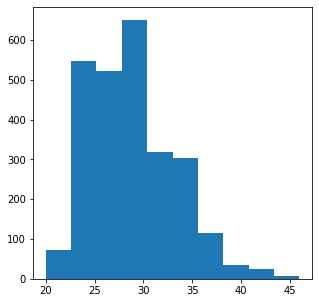

In [11]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.player_age)
plt.show()

4) p_game
> 경기 수를 나타내는 특성, 분석에 영향을 주기에는 힘듬

In [12]:
data.p_game.describe()

count    2593.000000
mean       31.417663
std         3.753428
min        10.000000
25%        30.000000
50%        32.000000
75%        33.000000
max        53.000000
Name: p_game, dtype: float64

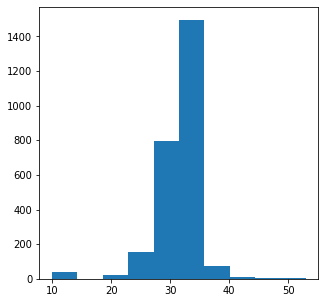

In [13]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_game)
plt.show()

5) p_formatterd_ip 
> 이닝 수, 선수마다 차이가 있으므로 평균을 이용할 때 사용

In [14]:
data.p_formatted_ip.describe()

count    2593.000000
mean      193.728538
std        28.321330
min        60.100000
25%       178.000000
50%       195.000000
75%       211.000000
max       271.200000
Name: p_formatted_ip, dtype: float64

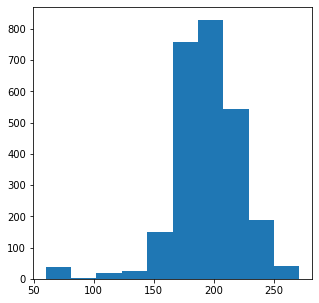

In [15]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_formatted_ip)
plt.show()

6) p_total_pa
> 전체 타석수, 이닝으로 평균화 시킬 것이기 때문에 불필요
/ 이닝 수랑 매우 비슷한 분포

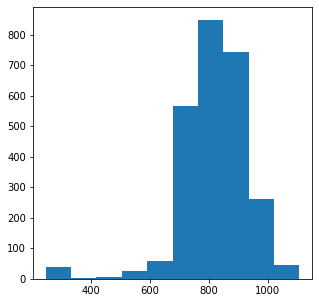

In [16]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_total_pa)
plt.show()

7) p_total_hits 
피안타, 승리와 연관이 있을거라 생각 / 실제 이닝 수 별로 차이가 있을 것이기때문에, 이닝 당 안타로 변환 필요

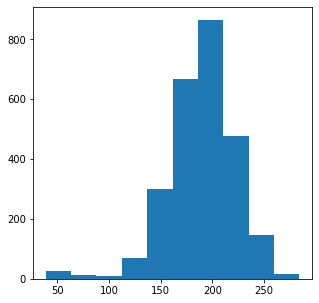

In [17]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_total_hits)
plt.show()

8) p_single / p_double / p_triple 
> 피안타로 통합해서 특성 확인 가능

9) p_home_run
> 피안타와 마찬가지로 이닝 수 별로 차이가나므로 이닝별 홈런으로 변환 필요


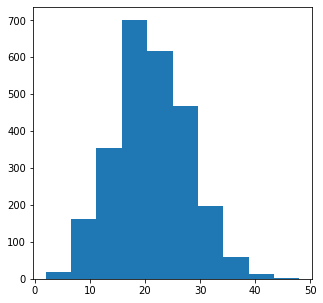

In [18]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_home_run)
plt.show()

10) p_strikeout / p_walk
> 스트라이크, 볼넷 개수 또한 이닝 수 별로 다르기 때문에 이닝별 개수로 변환

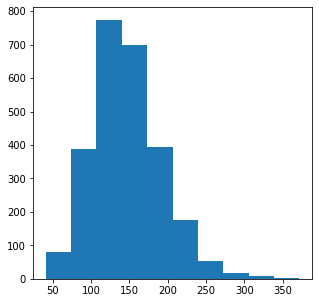

In [19]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_strikeout)
plt.show()

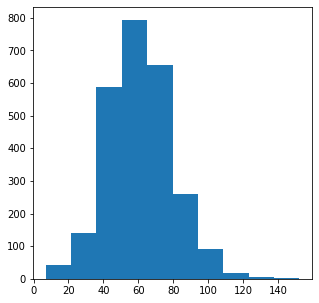

In [20]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_walk)
plt.show()

11) p_k_percent / p_bb_percent 
> 잡은 아웃의 삼진,볼넷 비율 / 퍼센트이므로 바로 사용 가능

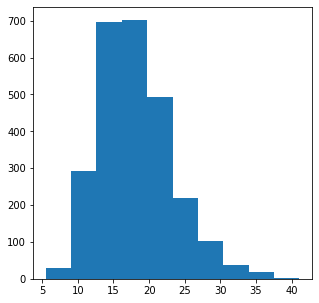

In [21]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_k_percent)
plt.show()

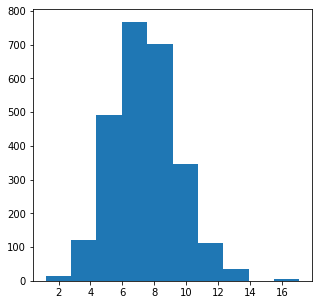

In [22]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_bb_percent)
plt.show()

12) p_earned_run / p_run
> 자책점, 실점 모두 이닝 별로 평균을 한 방어율로 통합하므로 불필요 특성

13) p_win
> 오히려 타겟에 영향을 받아 나올 특성


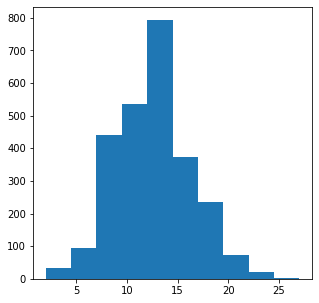

In [23]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_win)
plt.show()

14) p_loss
> 패 특성, 분석에 불 필요

15) p_era 
> 타겟 특성

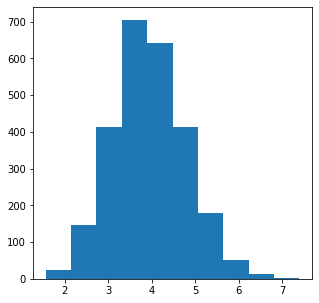

In [24]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_era)
plt.show()

16) p_quality_start 
> 6이닝 3실점 이하 횟수, 승리 수와 밀접한 연관 있음

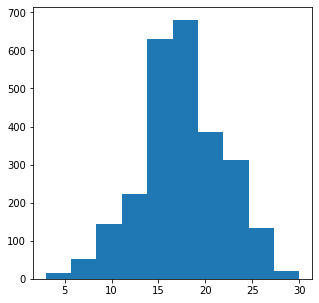

In [25]:
fig = plt.figure(figsize=(5,5))                                                      
plt.hist(data.p_quality_start)
plt.show()

17) p_ball / p_total_strike
> 볼, 스트라이크 개수, 전체 투구중 비율로 전환하여 비교가능

18) p_starting_p / avg_best_speed 
> 평균구속 데이터 결측이 너무많아 사용 불가능, 선발 횟수 분석에 무의미

## 데이터 전처리


In [26]:
data.isnull().sum()

name                  0
player_id          2141
year                  0
player_age            0
p_game                0
p_formatted_ip        0
p_total_pa            0
p_total_hits          0
p_single              0
p_double              0
p_triple              0
p_home_run            0
p_strikeout           0
p_walk                0
p_k_percent           0
p_bb_percent          0
slg_percent           0
p_earned_run          0
p_run                 0
p_win                 0
p_loss                0
p_era                 0
p_quality_start       0
p_ball               82
p_complete_game       0
p_starting_p          0
p_total_strike       82
avg_best_speed     2141
dtype: int64

In [27]:
data.duplicated().sum()

0

In [28]:
#데이터셋 전처리
def clean(df):
    df = df.copy()

    # id 변수 제거
    df = df.drop('player_id', axis = 1)

    # 최고 구속 변수 제거
    df = df.drop('avg_best_speed', axis = 1)

    # 스트라이크 수, 볼 수 비율로 전환 (전체 투구중 스트라이크 비율), 새 컬럼 생성
    df['s/total'] = df['p_total_strike'] / (df['p_total_strike']+df['p_ball'])

    # 스트라이크 , 볼 수 컬럼 제거 (비율로 전환 했으므로)
    df = df.drop('p_total_strike', axis = 1)
    df = df.drop('p_ball', axis = 1)

    # 결측치 평균으로 채우기
    df['s/total'] = df['s/total'].fillna(df['s/total'].mean())

    # 안타/홈런/삼진/볼넷 9이닝당 개수로 전환 , 새 컬럼 생성
    df['H/9'] = df['p_total_hits']/df['p_formatted_ip']*9
    df['HR/9'] = df['p_home_run']/df['p_formatted_ip']*9
    df['K/9'] = df['p_strikeout']/df['p_formatted_ip']*9
    df['BB/9'] = df['p_walk']/df['p_formatted_ip']*9

    # 안타/홈런/삼진/볼넷 비율로 전환했으므로 기존 컬럼 제거
    df = df.drop(['p_total_hits','p_home_run','p_strikeout', 'p_walk'], axis = 1)

    # 1루타/2루타/3루타 제거
    df = df.drop(['p_single','p_double','p_triple'], axis = 1)

    # 전체 타석 수 제거
    df = df.drop(['p_total_pa'], axis = 1)

    # 시즌 / 실점 / 자책점 / 선발 출전 제거
    df = df.drop(['year','p_earned_run','p_run', 'p_starting_p'], axis = 1)

    return df

In [29]:
df = clean(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2593 entries, 0 to 2592
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2593 non-null   object 
 1   player_age       2593 non-null   int64  
 2   p_game           2593 non-null   int64  
 3   p_formatted_ip   2593 non-null   float64
 4   p_k_percent      2593 non-null   float64
 5   p_bb_percent     2593 non-null   float64
 6   slg_percent      2593 non-null   float64
 7   p_win            2593 non-null   int64  
 8   p_loss           2593 non-null   int64  
 9   p_era            2593 non-null   float64
 10  p_quality_start  2593 non-null   int64  
 11  p_complete_game  2593 non-null   int64  
 12  s/total          2593 non-null   float64
 13  H/9              2593 non-null   float64
 14  HR/9             2593 non-null   float64
 15  K/9              2593 non-null   float64
 16  BB/9             2593 non-null   float64
dtypes: float64(10)

## 모델 설정


- baseline 모델 / 타겟 p_era특성의 평균을 기준모델로 사용


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


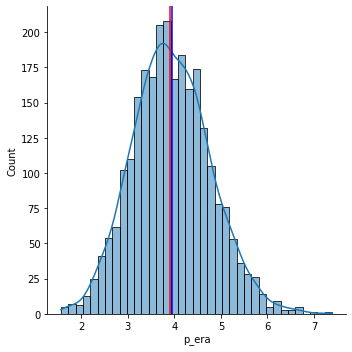

In [30]:
# p_win 의 확률밀도함수
sns.displot(df['p_era'], kde=True)

# 평균과, 중간값으로 수직선
plt.axvline(df['p_era'].mean(), color='blue')
plt.axvline(df['p_era'].median(), color='red');

In [31]:
# predict: 기준모델인 평균으로 예측
predict = df['p_era'].mean()
# 평균값으로 예측할 때 샘플 별 평균값과의 차이(error)를 저장
errors = predict - df['p_era']


In [32]:
# mean_absolute_error(MAE), error에 절대값을 취한 후 평균을 계산
baseline_mae = errors.abs().mean()
baseline_mae

0.6659932724031251

## 모델 선택

In [33]:
train, test = train_test_split(df,test_size=0.2, random_state=2)

print(train.shape, test.shape)

(2074, 17) (519, 17)


In [34]:
# 타겟 방어율
target = 'p_era'

X_train = train[train.columns[train.columns != target]]
X_test = test[test.columns[test.columns != target]]

y_train = train[target]
y_test = test[target]

In [35]:
# train, validation 나누기
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, train_size = 0.8, random_state=10)

print("train : ", X_train.shape, y_train.shape)
print("validation : ", X_val.shape, y_val.shape)
print("test : ", X_test.shape)

train :  (1659, 16) (1659,)
validation :  (415, 16) (415,)
test :  (519, 16)


In [36]:

# 모델 설정을 위한 커스텀 성과지표 마늘기
def mae_scorer(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def r2_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)

def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {'MAE': make_scorer(mae_scorer), 'RMSE': make_scorer(rmse_scorer), 'R2': make_scorer(r2_scorer)}

In [37]:
folds = 1
n, k =  Pipeline(steps=[('preprocessor', OrdinalEncoder())]).fit(X_train, y_train).transform(X_train).shape
n *= (1 - (1/folds))
n = int(n)
k -= 1

DTR = DecisionTreeRegressor(max_depth=8)

# Regression Classifiers
lr = LinearRegression()
ridge = Ridge(random_state = 2, alpha=10)
rf = RandomForestRegressor(random_state = 2, max_depth=8, n_estimators=150)
xgb = XGBRegressor(random_state = 2, max_depth=8, n_estimators=150)
lgbm = lgb.LGBMRegressor(random_state=2, max_depth=8, n_estimators=150)
gr = GradientBoostingRegressor(random_state=2, max_depth=8, n_estimators=150)
ada = AdaBoostRegressor(DTR,random_state=2, n_estimators=150)

classifiers = [
    ('LinearRegression', lr),
    ('Ridge', ridge),
    ('XGBRegressor', xgb),
    ('RandomForestRegressor', rf),
    ('LGBMRegressor', lgbm),
    ('GradientBoostingRegressor', gr),
    ('AdaBoostRegressor', ada)

]

clf_names = []
clf_scores = []

for clf_name, clf_model in classifiers:

    clf_names.append(clf_name)
    pipe = Pipeline(steps=[('preprocessor', OrdinalEncoder()),
                           ('model', clf_model)])
    
    cv_results = cross_validate(pipe, X_train, y_train, cv=3, scoring=scoring)
    
    mae = cv_results['test_MAE'].mean()
    rmse = cv_results['test_RMSE'].mean()
    r2 = cv_results['test_R2'].mean()
    clf_scores.append([mae, rmse, r2])
    

[01:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
# 모델 후보 MAE, RMSE, R2 지표
pd.DataFrame(clf_scores, columns = ['MAE', 'RMSE','R2'], index=clf_names).sort_values('RMSE')

,MAE,RMSE,R2
LinearRegression,0.252017,0.321962,0.852915
Ridge,0.255128,0.325801,0.849393
AdaBoostRegressor,0.282275,0.358066,0.818009
LGBMRegressor,0.278351,0.358233,0.817840
RandomForestRegressor,0.281908,0.359487,0.816632
XGBRegressor,0.279817,0.361591,0.814485
GradientBoostingRegressor,0.294030,0.375788,0.799571


베이스모델 보다 mae 값이 좋으므로 LinearRegression 사용

- 선형모델 장점
1. 결과예측(추론)속도가 빠르다
2. 대용량 데이터에도 충분히 활용 가능하다
3. 특성이 많은 데이터 세트라면 훌륭한 성능을 낼수있다
 

- 선형모델 단점
1. 특성이 적은 저차원 데이터에서는 다른 모델의 일반화성능이 더 좋을 수 있다 /특성확장을 하기도 한다.
2. LinearRegression Model은 복잡도를 제어할 방법이 없어 과대적합되기 쉽다.
따라서 모델 정규화(Regularization)을 통해 과대적합을 제어한다.


## 모델 개발

In [39]:
linear = Pipeline(steps=[('preprocessing', 
                          OrdinalEncoder()),
                        ('model', lr)])

In [40]:
linear.fit(X_train, y_train)
linear_predict = linear.predict(X_val)

mae = mean_absolute_error(y_val, linear_predict)
rmse = np.sqrt(mean_squared_error(y_val, linear_predict))
r2 = r2_score(y_val, linear_predict)

print(f'Test MAE: {mae:,.4f}')
print(f'Test RMSE: {rmse:,.4f}')
print(f'R2 Score: {r2:,.4f}\n')

print('검증정확도: ', linear.score(X_val, y_val))

Test MAE: 0.2212
Test RMSE: 0.2770
R2 Score: 0.8801

검증정확도:  0.8800663504797077


In [41]:
# permuter 정의
permuter = PermutationImportance(
    linear.named_steps['model'], # model
    scoring='neg_mean_squared_error', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = linear.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

In [42]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)


BB/9               2.783695
p_bb_percent       2.078398
H/9                0.229893
HR/9               0.125590
p_quality_start    0.094881
p_loss             0.017872
p_formatted_ip     0.015635
K/9                0.002910
s/total            0.002108
p_k_percent        0.001658
p_complete_game    0.001044
slg_percent        0.000991
p_game             0.000285
name               0.000083
player_age        -0.000012
p_win             -0.000012
dtype: float64

In [43]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식
)


Weight,Feature
2.7837 ± 0.1728,BB/9
2.0784 ± 0.1788,p_bb_percent
0.2299 ± 0.0285,H/9
0.1256 ± 0.0148,HR/9
0.0949 ± 0.0147,p_quality_start
0.0179 ± 0.0021,p_loss
0.0156 ± 0.0048,p_formatted_ip
0.0029 ± 0.0024,K/9
0.0021 ± 0.0021,s/total
0.0017 ± 0.0016,p_k_percent


In [44]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]

X_train_selected = X_train[features]
X_val_selected = X_val_transformed[features]
X_test_selected = X_test[features]

In [45]:
print('특성 삭제 후:', X_train_selected.shape, X_test_selected.shape, X_val_selected.shape)


특성 삭제 후: (1659, 11) (519, 11) (415, 11)


In [46]:
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linear = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    LinearRegression()
)

linear.fit(X_train_selected, y_train)
linear_predict = linear.predict(X_val_selected)

mae = mean_absolute_error(y_val, linear_predict)
rmse = np.sqrt(mean_squared_error(y_val, linear_predict))
r2 = r2_score(y_val, linear_predict)

print(f'Test MAE: {mae:,.4f}')
print(f'Test RMSE: {rmse:,.4f}')
print(f'R2 Score: {r2:,.4f}\n')

print('검증정확도: ', linear.score(X_val_selected, y_val))

Test MAE: 0.2209
Test RMSE: 0.2764
R2 Score: 0.8806

검증정확도:  0.8805818874641228


In [47]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True)
    , SimpleImputer()
    , StandardScaler()
    , SelectKBest(f_regression)
    , Ridge()
)

# 튜닝할 하이퍼파라미터의 범위를 지정해 주는 부분
dists = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1, 10], 
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train_selected, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
51 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.8/dist-package

In [48]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)


최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 11, 'ridge__alpha': 0.1}
MAE:  0.2506159970539763


- 하이퍼파라미터 튜닝을 통해 능형회귀 모델을 비교해보았으나 성능이 오히려 떨어짐

## 최종 모델

In [49]:
final_model = make_pipeline(
    TargetEncoder(),
    StandardScaler(),
    LinearRegression()
)

final_model.fit(X_train_selected, y_train)

model_predict = final_model.predict(X_test_selected)

mae = mean_absolute_error(y_test, model_predict)
rmse = np.sqrt(mean_squared_error(y_test, model_predict))
r2 = r2_score(y_test, model_predict)

print(f'Test MAE: {mae:,.4f}')
print(f'Test RMSE: {rmse:,.4f}')
print(f'R2 Score: {r2:,.4f}\n')

print('검증정확도: ', final_model.score(X_test_selected, y_test))

Test MAE: 0.2310
Test RMSE: 0.2925
R2 Score: 0.8785

검증정확도:  0.8785412509706004


/usr/local/lib/python3.8/dist-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/usr/local/lib/python3.8/dist-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [50]:
# 회귀계수
coefficients = final_model.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

p_formatted_ip     0.102452
p_k_percent       -0.043829
p_bb_percent      -0.931563
p_loss             0.090564
p_quality_start   -0.227944
p_complete_game   -0.022068
s/total           -0.033427
H/9                0.333396
HR/9               0.235543
K/9                0.051094
BB/9               1.102134
dtype: float64

In [51]:
plt.rcParams['figure.dpi'] = 144


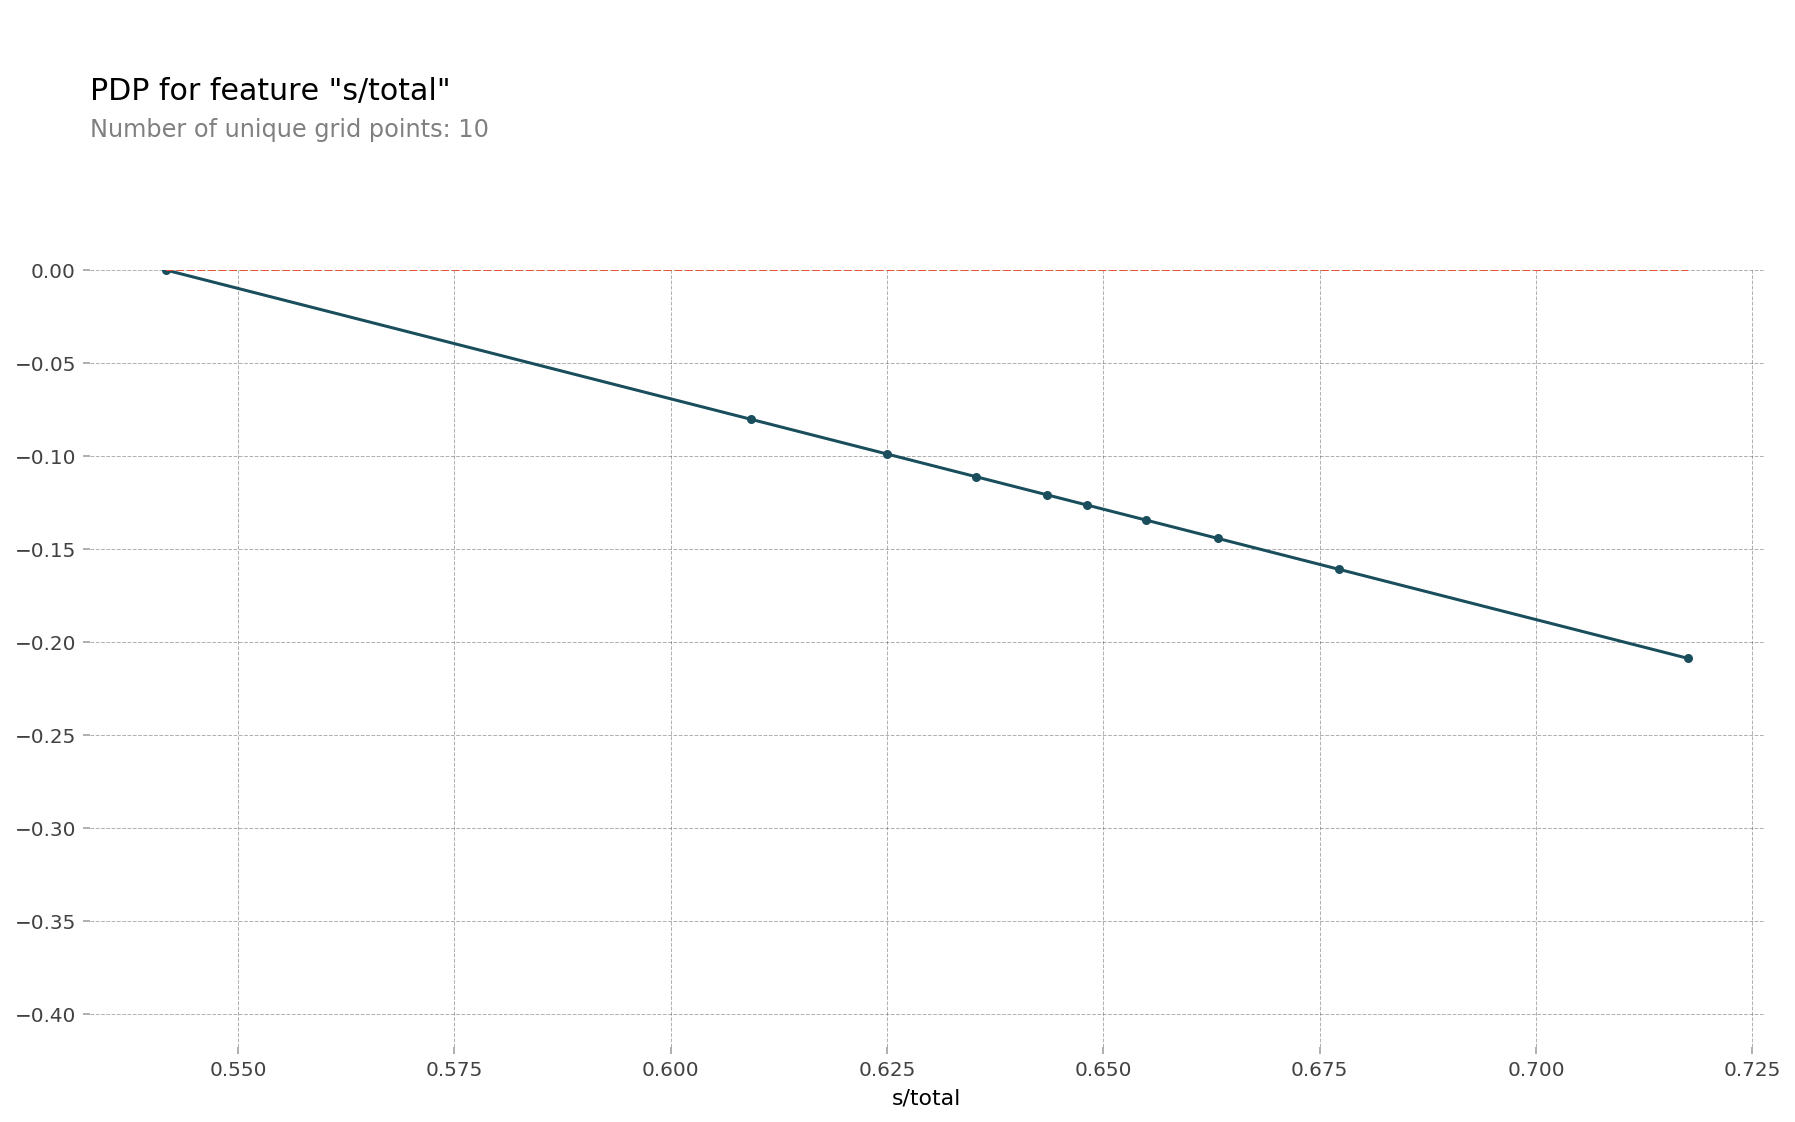

In [59]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 's/total'
isolated = pdp_isolate(
    model=final_model, 
    dataset=X_test_selected, 
    model_features=X_test_selected.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);


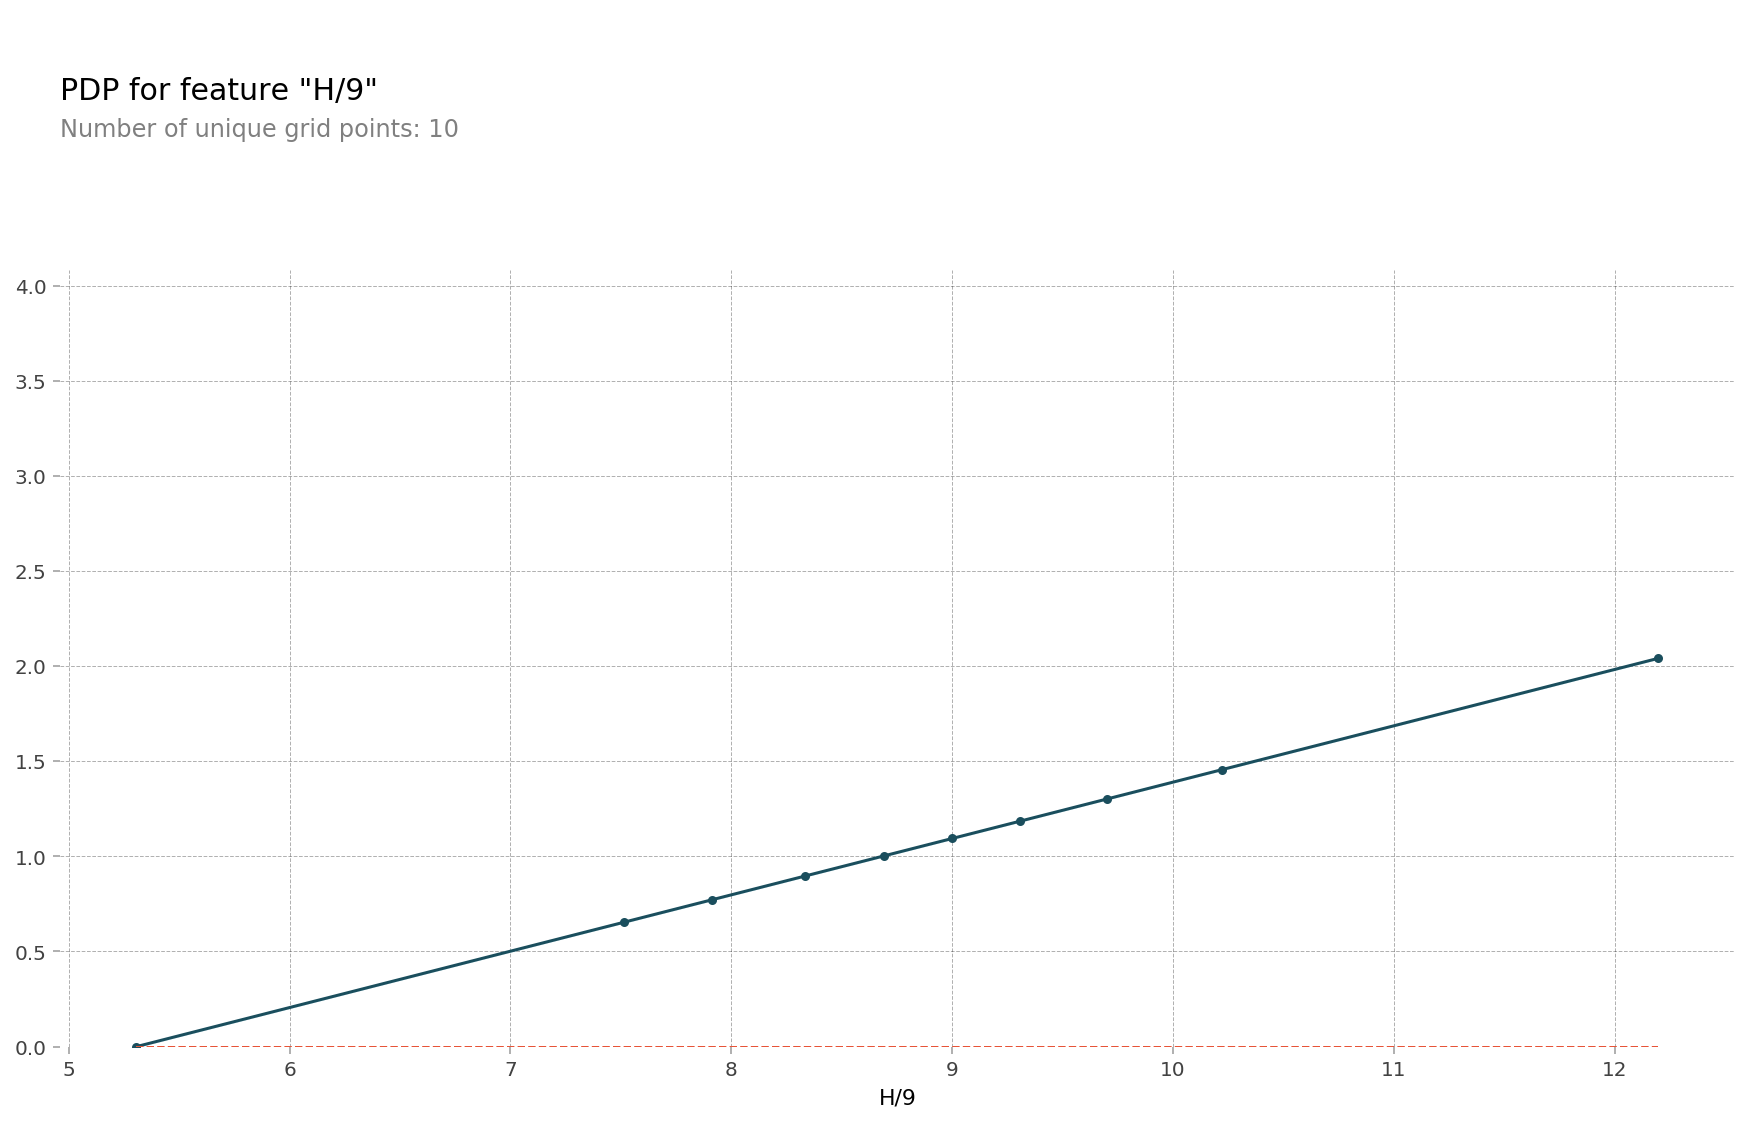

In [60]:
feature = 'H/9'
isolated = pdp_isolate(
    model=final_model, 
    dataset=X_test_selected, 
    model_features=X_test_selected.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);


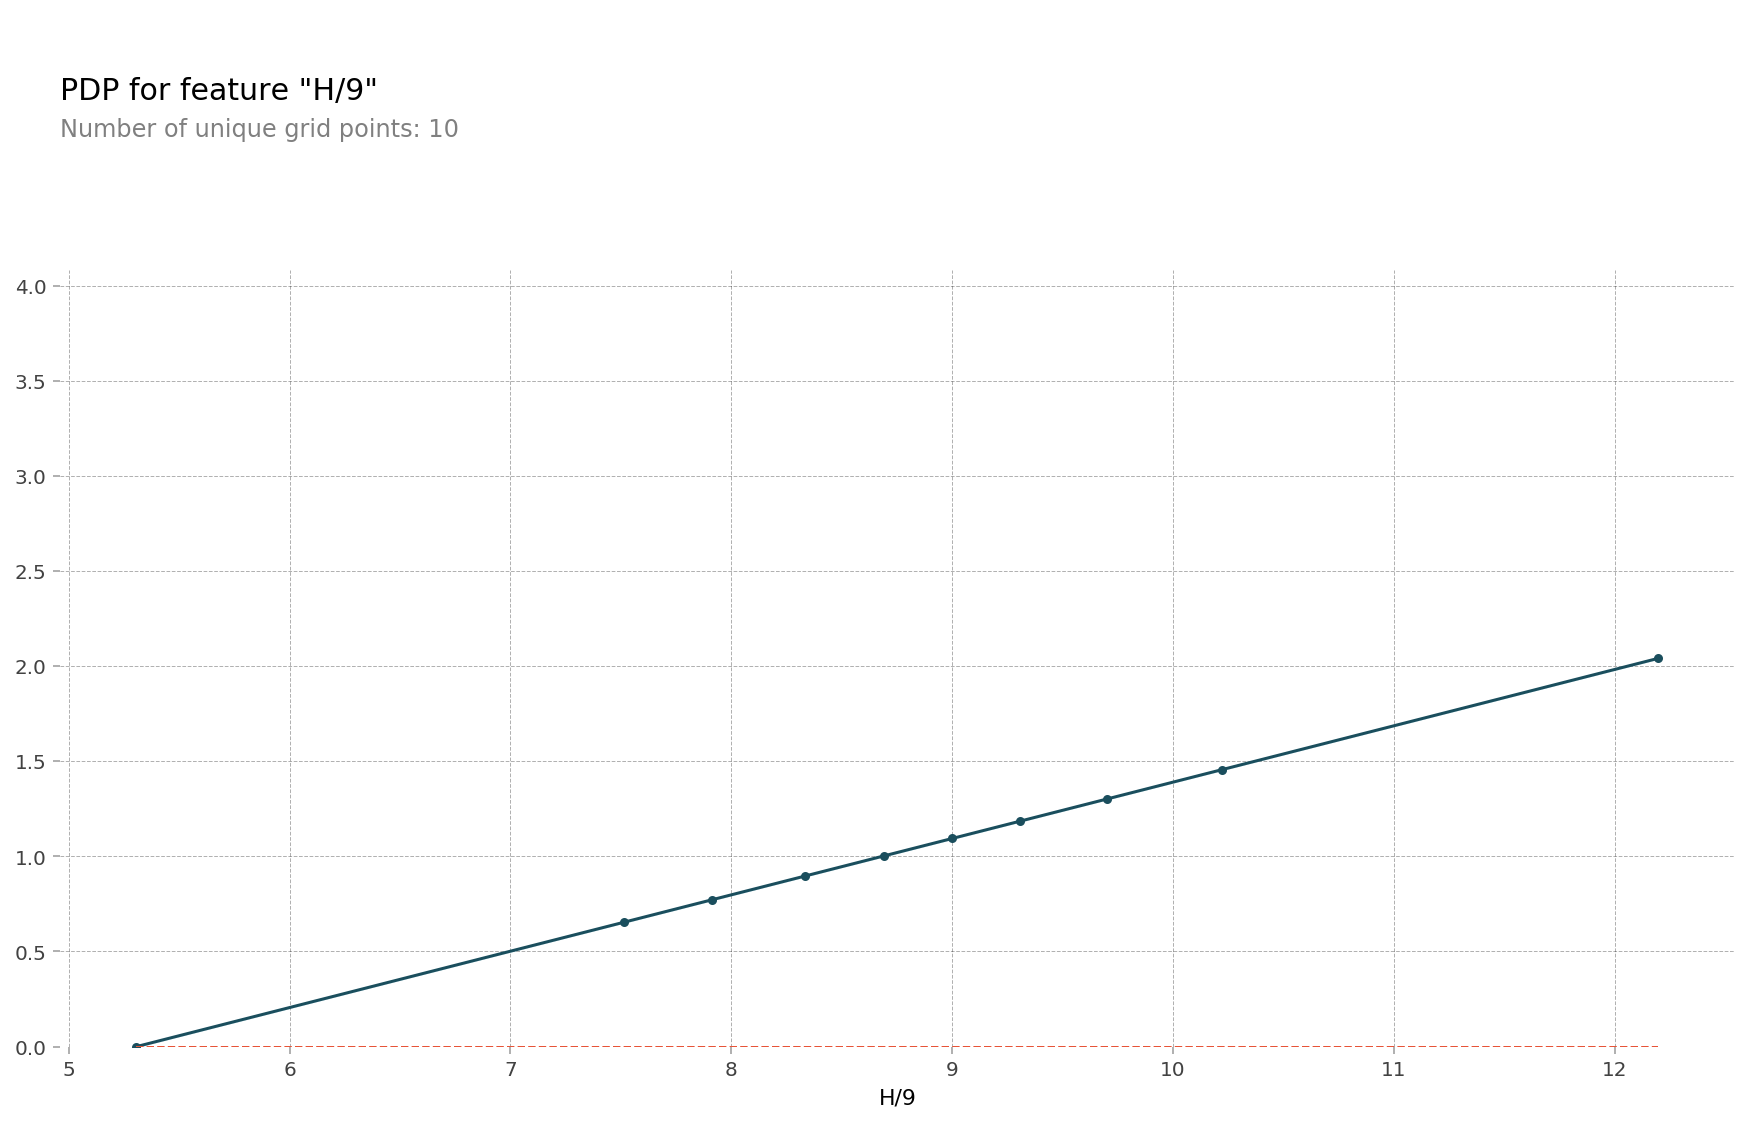

In [54]:
feature = 'H/9'
isolated = pdp_isolate(
    model=final_model, 
    dataset=X_test_selected, 
    model_features=X_test_selected.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [55]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [61]:
features = ['HR/9', 'H/9']

interaction = pdp_interact(
    model=final_model, 
    dataset=X_test_selected,
    model_features=X_test_selected.columns, 
    features=features
)


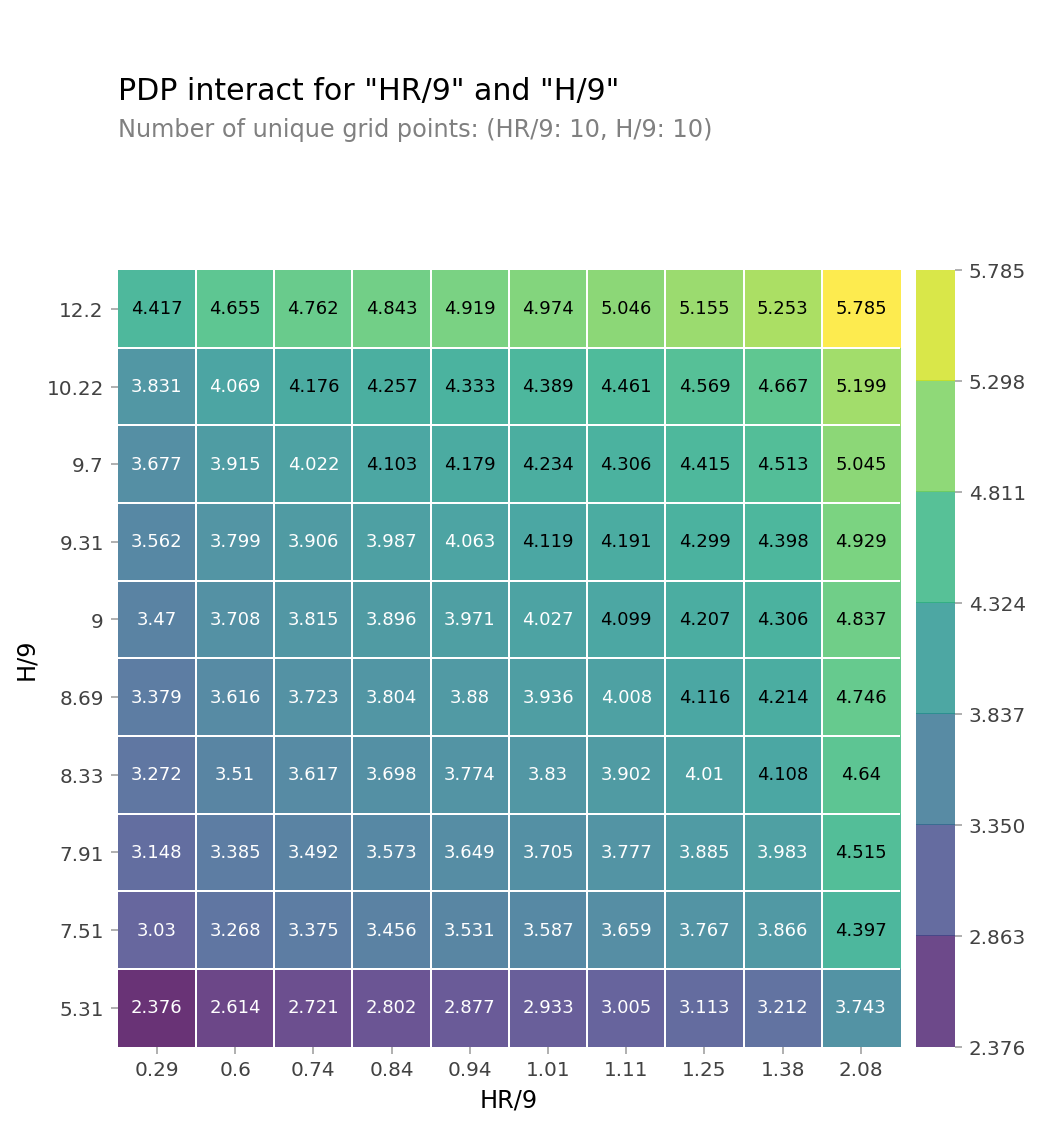

In [62]:

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);
